<a href="https://colab.research.google.com/github/deClot/Hakaton_Superhero/blob/master/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from plotly.offline import init_notebook_mode, iplot

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)
 
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)


plt.rcParams['figure.figsize'] = [10,5]

In [2]:
def get_season(x):
  return 1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_year'] = df[t].dt.year
        df[t+'_month'] = df[t].dt.month
        df[t+'_season'] = df[t+'_month'].apply(get_season)
        df[t+'_is_month_start'] = df[t].dt.is_month_start
        df[t+'_is_month_end'] = df[t].dt.is_month_end
        df[t+'_day'] = df[t].dt.day
        # df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = df[t+'_dayofweek'] >= 5
        df[t+'_quarter'] = df[t].dt.quarter

def get_regions(df):
  base = {'Кукморский': 'Кукмор',
          'Мамадышский': 'Мамадыш',
          'Нурлатский': 'Нурлат',
          'Азнакаевский': 'Азнакаево', 
          'Апастовский':'Апастово',
          'Бугульминский': 'Бигульма',
          'Елабужский':'Елабуга',
          'Бавлинский':'Бавлы',
          'Нижегородский':'Нижний Новгород',
          'Чистопольский':'Чистополь',
          'Вятские поляны': 'Вятские Поляны',
          'Новгород Великий':'Новгород'}
  to_cut = {k:k[:-2]  for k in reg if 'ский' in k}

  temp = df.LivingRegionName.copy().astype('object')
  temp[temp.isin(base.keys())] = temp[temp.isin(base.keys())].map(base)
  temp[temp.isin(to_cut.keys())]  = temp[temp.isin(to_cut.keys())] .map(to_cut)
  temp = temp.map(city_to_regions)
  # temp[df.LivingRegionName=='Москва'] = 'Москва'
  assert temp.isna().sum() == 0

  df.LivingRegionName = temp.astype('category')



In [3]:
df = pd.read_excel('3_train.xlsx')
df.shape

(8501, 24)

In [4]:
df.rename(columns={'ConfirmedMonthlyIncome (Target)': 'target'}, inplace=True)
df.drop('NaturalPersonID', axis=1, inplace=True)
df.kolichestvo_detej_mladshe_18 = df.kolichestvo_detej_mladshe_18.astype('object')

preprocess_datetime(df, ['RequestDate'])
df = df.drop('RequestDate', axis=1)
features_time = [f for f in df.columns if 'RequestDate_' in f]

features_cat =  df.select_dtypes('object').columns.tolist()
# df[features_cat] = df[features_cat].astype('category')
features_num = [f for f in df.columns if f not  in features_cat and f not in features_time]

assert len(features_num) + len(features_cat) + len(features_time) == df.shape[1]

In [5]:
df.drop(['SignIP.1', 'Employment.1','TypeOfWork.1'], axis=1, inplace=True)
for f in ['SignIP.1', 'Employment.1','TypeOfWork.1'] :
  features_cat.remove(f)

In [6]:
regions = pd.read_json('russia')
city_to_regions = regions.set_index('city').to_dict()['region']

reg = [f for f in df.LivingRegionName.unique() if 'ский' in f]
city = [f for f in df.LivingRegionName.unique() if f not in reg]
df['in_region'] = np.where(df.LivingRegionName.isin(reg), 1,0)
get_regions(df)

In [7]:
df['age_cat'] = pd.cut(df.age, bins=(0, 23, 30, 40, 50, 65, 100), labels=[0,1,2,3,4,5])
features_cat.append('age_cat')
features_num.remove('age')

In [8]:
df = df[(df.otrasl_rabotodatelya.notna())&(df.kolichestvo_rabotnikov_v_organizacii.notna())]
df.SignIP = df.SignIP.astype('object').fillna(0)#.astype('category')

In [9]:
df.TypeOfWork[df.SignIP=='ИП'] = 'Индивидуальный предприниматель'

In [10]:
df.Employment[df.SignIP=='ИП'] = 'Индивидуальный предприниматель'
df.Employment.fillna('нет данных', inplace=True)
df.Employment.value_counts()

Сотрудник \ Рабочий \ Ассистент                   5982
Главный Специалист\Руководитель среднего звена    1292
Эксперт\Старший или Ведущий Специалист             672
Руководитель высшего звена                         492
Индивидуальный предприниматель                      59
нет данных                                           3
Name: Employment, dtype: int64

In [11]:
# сотрудники банка работают на полную ставку - заполнение пропска по типу работы
df.loc[(df.IsBankWorker=='да')&(df.harakteristika_tekutschego_trudoustrojstva.isna()),
       'harakteristika_tekutschego_trudoustrojstva'] = 'Постоянная, полная занятость'
df.harakteristika_tekutschego_trudoustrojstva.isna().sum()

8

In [12]:
df[df.harakteristika_tekutschego_trudoustrojstva.isna()].SignIP

102     ИП
830      0
904     ИП
1049    ИП
2966     0
3656    ИП
6188     0
7022     0
Name: SignIP, dtype: object

In [13]:
df.IncomeDocumentKind = df.IncomeDocumentKind.astype('object').fillna('Нет запрашивали')#.astype('category')

In [14]:
df.Residence = df.Residence.astype('object').fillna('na')#.astype('category')

In [15]:
df.TypeOfWork = df.TypeOfWork.astype('object').fillna('na')#.astype('category')

In [16]:
# bins = [-1, 25,75,125,175,225,275,325,375,425,475,550,650,750,850,950,1250,1750,2500,3500]
# labels = [25,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000,1500,2000,3000]
# credit = pd.cut(temp/10**3, bins=bins, labels=labels).astype('int')

In [17]:
df['OrgNtoAge'] = (df.OrgStanding_N)/(df.age-20)

In [18]:
features_num.remove('target')

# Income

In [19]:
# https://www.gks.ru/labor_market_employment_salaries?print=1
# https://www.gks.ru/folder/13397

In [20]:
df.LivingRegionName = df.LivingRegionName.astype('object').str.replace('Башкирия', '')\
                                    .str.replace('Горьковская', 'обл.')\
                                    .str.replace('(', '').str.replace(')', '')\
                                    .str.replace('Чувашия', 'Чувашская Республика')\
                                    .str.replace('Удмуртия', 'Удмуртская Республика')\
                                    .str.replace('Татарстан', 'Республика Татарстан')\
                                    .str.replace('Марий Эл', 'Республика Марий Эл') \
                                    .str.replace('Башкортостан', 'Республика Башкортостан')\
                                    .str.replace('Санкт-Петербург и область', 'г.Санкт-Петербург')\
                                    .str.replace('Москва и Московская обл.', 'г.Москва')

In [21]:
def get_income_region(x):
  year, period = x.RequestDate_year, x.RequestDate_quarter
  assert np.isin(x.LivingRegionName, incom_region.region)
  return incom_region[(incom_region.region == x.LivingRegionName)][(year,period)].iat[0]

In [22]:
# salary_nominal_region = pd.read_excel('t2.xlsx')
# salary_nominal_region_year = pd.read_excel('t4.xlsx')
# salary_real_region_year_ration = pd.read_excel('t5.xlsx')
# # salary_nominal_otrals = pd.read_excel('t6.xls', header=5)
# # salaty_nominal_otrasl_year = pd.read_excel('t3.xlsx')
incom_region = pd.read_excel('urov_10sub-nm.xlsx', header=4)
# # mrot = pd.read_excel('data.xls')

In [23]:
incom_region.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
incom_region.columns = pd.MultiIndex.from_product([np.arange(2013,2021), (1,2,3,4,'total')]).insert(0, incom_region.columns[0])
incom_region.region = incom_region.region.str.strip().str.replace('область', 'обл.')

In [24]:
%%time
df['income_region'] = df.apply(get_income_region, axis=1)

CPU times: user 31.6 s, sys: 192 ms, total: 31.8 s
Wall time: 31.5 s


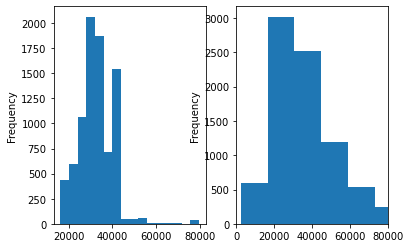

In [25]:
ax=plt.subplot(121)
df.income_region.plot(kind='hist',ax=ax, bins=16)
ax=plt.subplot(122)
df.target.plot(kind='hist', ax=ax, xlim=(0,80000), bins=20)

# Model

In [26]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import xgboost as xgb

from lightgbm import LGBMRegressor, cv
import lightgbm as lgb

def get_train_val(X, y, cv5):
  for train_idx, val_idx in cv5.split(X, y):
      X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
      X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
      break
  return X_train, y_train, X_val, y_val 

In [27]:
# df_ini = df.copy()

In [28]:
features_cat.append('in_region')

In [29]:
to_drop = ['target'] +['age_cat', 'RequestDate_day']# [f for f in df_ohe.columns if 'age' not in f]
display(to_drop)


target = df.target
df[features_cat] = df[features_cat].astype('category')
df[features_time] = df[features_time].astype('category')
X_ini, X_test_ini, y_ini, y_test_ini = train_test_split(df.drop(to_drop, axis=1), target,
                                        random_state=2021)

cv5 = ShuffleSplit(5, test_size=0.2, random_state=2020)
X_train,y_train,X_val,y_val = get_train_val(X_ini, pd.Series(y_ini), cv5)

['target', 'age_cat', 'RequestDate_day']

In [30]:
X_ini.dtypes

ProductName                                   category
CreditSum                                      float64
TypeOfWork                                    category
Employment                                    category
SignIP                                        category
sex                                           category
age                                              int64
EducationStatus                               category
otrasl_rabotodatelya                          category
kolichestvo_rabotnikov_v_organizacii          category
OrgStanding_N                                  float64
kolichestvo_detej_mladshe_18                  category
LivingRegionName                              category
Residence                                     category
IncomeDocumentKind                            category
HaveSalaryCard                                category
IsBankWorker                                  category
harakteristika_tekutschego_trudoustrojstva    category
RequestDat

((5100,), (1275,), (2125,))

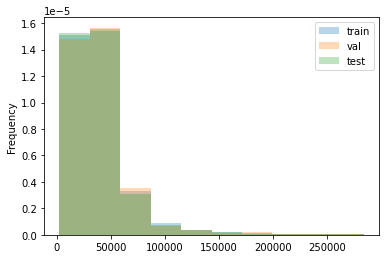

In [31]:
temp = pd.concat([y_train, y_val, y_test_ini],axis=1)
temp.columns = ['train', 'val', 'test']
temp.plot(kind='hist', density=True, alpha=0.3);
y_train.shape, y_val.shape, y_test_ini.shape

In [32]:
def features_scaler(features, X, X_test):
  scaler = StandardScaler()
  X_scaler, X_test_scaler = X.copy(), X_test.copy()
  X_scaler[features_num] = scaler.fit_transform(X[features_num])
  X_test_scaler[features_num] = scaler.transform(X_test[features_num])

  return X_scaler, X_test_scaler


def features_log(features, X, X_test):
  X_log, X_test_log = X.copy(), X_test.copy()
  X_log[features] = np.log1p(X[features])
  X_test_log[features] = np.log1p(X_test[features])
  return X_log, X_test_log


def features_ohe(features, X, X_test):
  train_size = X.shape[0]
  df = pd.concat([X, X_test])
  df = pd.concat([df.drop(features, axis=1), 
                  pd.get_dummies(df[features].astype('object'), 
                                 drop_first=True)],#dummy_na=True
                  axis=1)
  return df.iloc[:train_size], df.iloc[train_size:]


def features_le(features, X, X_test):
  train_size = X.shape[0]
  df = pd.concat([X, X_test])
  for f in features:
    df[f] = df[f].astype('category').cat.codes
  
  return df.iloc[:train_size], df.iloc[train_size:]

def employ_ip_to_rukovoditel(X, X_test):
  # X.Employment = X.Employment.astype('object')
  X.loc[X.Employment=='Индивидуальный предприниматель', 'Employment'] = 'Руководитель высшего звена'
  # X_test.Employment = X_test.Employment.astype('object')
  X_test.loc[X_test.Employment=='Индивидуальный предприниматель', 'Employment'] = 'Руководитель высшего звена'


def move_na_train_to_test(features, X, y, X_test, y_test):
  X_test = pd.concat([X_test, X[X[features].isna().any(axis=1)]])
  y_test = pd.concat([y_test, y[X[features].isna().any(axis=1)]])
  y = y[X[features].notna().all(axis=1)]
  X = X[X[features].notna().all(axis=1)]
  return X, y, X_test, y_test

def move_value_train_to_test(values, feature, X,y, X_test,y_test):
  X_test = pd.concat([X_test, X[X[feature].isin(values)]])
  y_test = pd.concat([y_test, y[X[feature].isin(values)]])
  y = y[~X[feature].isin(values)]
  X = X[~X[feature].isin(values)]
  return X, y, X_test, y_test

def del_by_values(values, feature, X, y, region=False):
  if region:
    idx = X[(X[feautre] >= region[0])*(X[feature]<=region[1])]
  else:
    idx = X[feature].isin(values)
  return X[~idx], y[~idx]


In [33]:
X_ini.columns

Index(['ProductName', 'CreditSum', 'TypeOfWork', 'Employment', 'SignIP', 'sex',
       'age', 'EducationStatus', 'otrasl_rabotodatelya',
       'kolichestvo_rabotnikov_v_organizacii', 'OrgStanding_N',
       'kolichestvo_detej_mladshe_18', 'LivingRegionName', 'Residence',
       'IncomeDocumentKind', 'HaveSalaryCard', 'IsBankWorker',
       'harakteristika_tekutschego_trudoustrojstva', 'RequestDate_year',
       'RequestDate_month', 'RequestDate_season', 'RequestDate_is_month_start',
       'RequestDate_is_month_end', 'RequestDate_dayofweek',
       'RequestDate_is_weekend', 'RequestDate_quarter', 'in_region',
       'OrgNtoAge', 'income_region'],
      dtype='object')

In [34]:
X, X_test = X_ini.copy(), X_test_ini.copy()
y, y_test = y_ini.copy(), y_test_ini.copy()

# doesnt change
# idx = (X.harakteristika_tekutschego_trudoustrojstva.isna()) & (X.SignIP==0)
# X = X[~idx]
# y = y[~idx]

# X, y, X_test, y_test = move_na_train_to_test(['CreditSum', 'harakteristika_tekutschego_trudoustrojstva'],
#                                              X,y, X_test, y_test) # !!!!

# X.CreditSum.fillna(0, inplace=True) #doesn't help
# X_test.CreditSum.fillna(0, inplace=True)

# employ_ip_to_rukovoditel(X, X_test)# !!!!!

# X.loc[X.Residence == 'na', 'Residence'] = 'село'
# X_test.loc[X_test.Residence == 'na', 'Residence'] = 'село'

# X, y = del_by_values(['Иное', 'Нет (не предоставлен)'], 'IncomeDocumentKind', X, y ) #!!!!!
# X, y = del_by_values([0], 'CreditSum', X,y) # !!!!!


params = {
          'learning_rate': 0.02,
          'num_leaves': 17,
          'min_child_samples': 15,
          'objective': 'mean_squared_error',
          'n_jobs': -1,
          }
dtest = lgb.Dataset(X_test, y_test)
dtrain = lgb.Dataset(X, y)

num_boost = 1000
clip_val = 150000
salary_min = 7000

score = []
for train_idx, val_idx in cv5.split(X, y):
  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

  X_train, y_train = del_by_values(['Иное', 'Нет (не предоставлен)'], 'IncomeDocumentKind', X_train, y_train) #!!!!!
  X_train, y_train = del_by_values([0], 'CreditSum', X_train,y_train) # !!!!! 
  # y_train = y_train[X_train.CreditSum <= 3.5*10**6]
  # X_train = X_train[X_train.CreditSum <= 3.5*10**6]
  # X_train = X_train[y_train > salary_min]
  # y_train = y_train[y_train > salary_min]
  y_train = y_train.clip(0, clip_val)

  dtrain = lgb.Dataset(X_train, y_train)
  clf = lgb.train(params, dtrain, num_boost_round=700)
  pred = clf.predict(X_val)
  score.append(np.sqrt(mean_squared_error(y_val, pred)))

print(np.mean(score), np.std(score))
# res = cv(params, dtrain, num_boost_round=num_boost, folds=cv5)
# print(np.sqrt(np.mean(res['l2-mean'])))
# pd.Series(np.sqrt(res['l2-mean'])).plot();

20080.998363963397 1028.608039384622


20443.65110552904


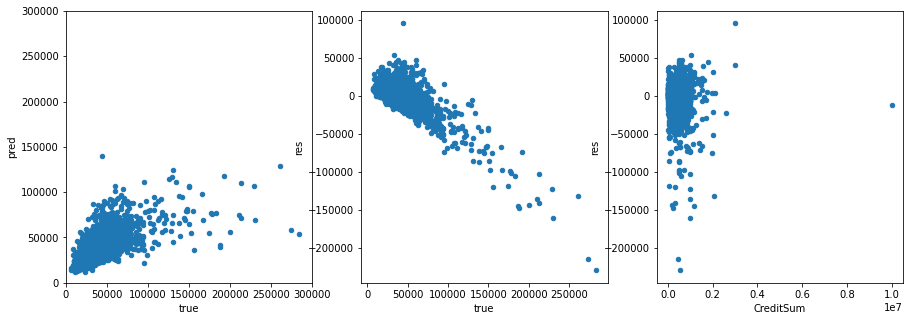

In [35]:
clf = lgb.train(params, dtrain, num_boost_round=700)
pred = clf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, pred)))

plt.figure(figsize=(15,5))
ax = plt.subplot(131)
pd.DataFrame(np.vstack([y_test.values,pred]).T, columns=['true', 'pred']) \
    .plot(x='true', y='pred', kind='scatter', ax=ax,
          xlim=(-1,300000), ylim=(-1, 300000));
ax = plt.subplot(132)
pd.DataFrame(np.vstack([y_test.values, pred -y_test ]).T, columns=['true', 'res']) \
    .plot(x='true', y='res', kind='scatter', ax=ax)
          # xlim=(-1,300000), ylim=(-1, 300000), figsize=(8,8));
ax = plt.subplot(133)
pd.DataFrame(np.vstack([X_test.CreditSum, pred -y_test ]).T, columns=['CreditSum', 'res']) \
    .plot(x='CreditSum', y='res', kind='scatter', ax=ax,) #xlim=(0, 0.35*10**7))

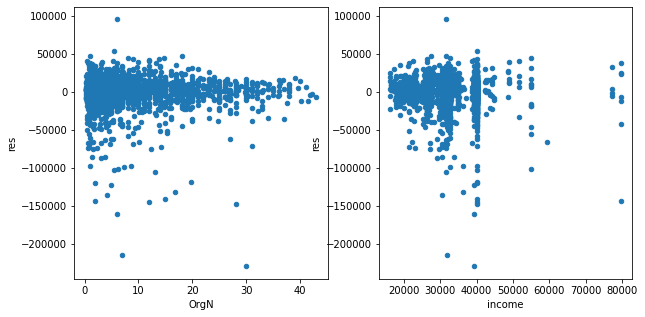

In [203]:
plt.figure(figsize=(10,5))

ax=plt.subplot(121)
pd.DataFrame(np.vstack([X_test.OrgStanding_N, pred-y_test ]).T, columns=['OrgN', 'res']) \
    .plot(x='OrgN', y='res', kind='scatter', ax=ax)
ax = plt.subplot(122)
pd.DataFrame(np.vstack([X_test.income_region, pred-y_test ]).T, columns=['income', 'res']) \
    .plot(x='income', y='res', kind='scatter', ax=ax)



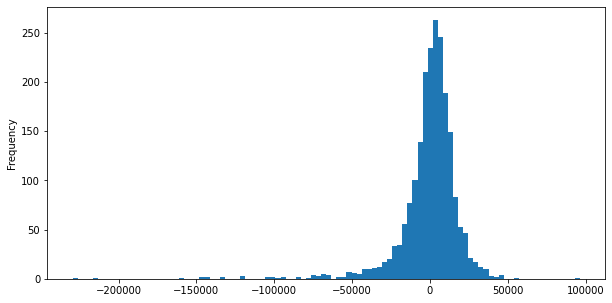

In [93]:
(pred-y_test).plot(kind='hist', bins=100);

In [ ]:
X, X_test = X_ini.copy(), X_test_ini.copy()
y, y_test = y_ini.copy(), y_test_ini.copy()

# doesnt change
# idx = (X.harakteristika_tekutschego_trudoustrojstva.isna()) & (X.SignIP==0)
# X = X[~idx]
# y = y[~idx]

# X, y, X_test, y_test = move_na_train_to_test(['CreditSum', 'harakteristika_tekutschego_trudoustrojstva'],
#                                              X,y, X_test, y_test) # !!!!

# X.CreditSum.fillna(0, inplace=True) #doesn't help
# X_test.CreditSum.fillna(0, inplace=True)

# employ_ip_to_rukovoditel(X, X_test)# !!!!!

# X.loc[X.Residence == 'na', 'Residence'] = 'село'
# X_test.loc[X_test.Residence == 'na', 'Residence'] = 'село'

# X, y = del_by_values(['Иное', 'Нет (не предоставлен)'], 'IncomeDocumentKind', X, y ) #!!!!!
# X, y = del_by_values([0], 'CreditSum', X,y) # !!!!!


params = {
          'learning_rate': 0.02,
          'num_leaves': 17,
          'min_child_samples': 15,
          'objective': 'mean_squared_error',
          'n_jobs': -1,
          }
dtest = lgb.Dataset(X_test, y_test)
dtrain = lgb.Dataset(X, y)

num_boost = 1000
clip_val = 150000
salary_min = 7000

score = []
for train_idx, val_idx in cv5.split(X, y):
  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

  X_train, y_train = del_by_values(['Иное', 'Нет (не предоставлен)'], 'IncomeDocumentKind', X_train, y_train) #!!!!!
  X_train, y_train = del_by_values([0], 'CreditSum', X_train,y_train) # !!!!! 
  # y_train = y_train[X_train.CreditSum <= 3.5*10**6]
  # X_train = X_train[X_train.CreditSum <= 3.5*10**6]
  # X_train = X_train[y_train > salary_min]
  # y_train = y_train[y_train > salary_min]
  y_train = y_train.clip(0, clip_val)

  dtrain = lgb.Dataset(X_train, y_train)
  clf = lgb.train(params, dtrain, num_boost_round=700)
  pred = clf.predict(X_val)
  score.append(np.sqrt(mean_squared_error(y_val, pred)))

print(np.mean(score), np.std(score))
# res = cv(params, dtrain, num_boost_round=num_boost, folds=cv5)
# print(np.sqrt(np.mean(res['l2-mean'])))
# pd.Series(np.sqrt(res['l2-mean'])).plot();

In [102]:
res = pd.DataFrame(np.vstack([X_test.OrgStanding_N, pred-y_test ]).T, columns=['OrgN', 'res']) 
miss = X_test.iloc[(np.abs(res.res) > 100000).values]
miss.nunique().sort_values()

RequestDate_is_month_end                       1
harakteristika_tekutschego_trudoustrojstva     1
RequestDate_is_weekend                         1
RequestDate_year                               2
RequestDate_is_month_start                     2
HaveSalaryCard                                 2
ProductName                                    2
SignIP                                         2
in_region                                      2
sex                                            2
IsBankWorker                                   2
EducationStatus                                3
RequestDate_quarter                            3
RequestDate_season                             3
TypeOfWork                                     3
LivingRegionName                               3
Residence                                      3
IncomeDocumentKind                             4
kolichestvo_detej_mladshe_18                   4
kolichestvo_rabotnikov_v_organizacii           4
Employment          

In [165]:
t = pd.concat([pred-y_test,y_test], axis=1)
t[t.iloc[:,1]<50000][t.iloc[:,0]>80000]

,target,target
7151,84357.438382,44258.92


In [116]:
X_test.loc[7151], y_test.loc[7151], t.loc[7151].sum()

(ProductName                                   Кредит на потребительские нужды
 CreditSum                                                               3e+06
 TypeOfWork                                                           по найму
 Employment                                         Руководитель высшего звена
 SignIP                                                                      0
 sex                                                                   Мужской
 age                                                                        31
 EducationStatus                                            Высшее образование
 otrasl_rabotodatelya                                                   Прочее
 kolichestvo_rabotnikov_v_organizacii                                  101-500
 OrgStanding_N                                                               6
 kolichestvo_detej_mladshe_18                                                1
 LivingRegionName                                   

In [205]:
X_test.sex, y_test.loc[7151], t.loc[7151].sum()

(6881    Женский
 6832    Женский
 7368    Мужской
 4702    Мужской
 1115    Женский
          ...   
 5007    Женский
 7750    Мужской
 5546    Мужской
 22      Женский
 3506    Женский
 Name: sex, Length: 2125, dtype: category
 Categories (2, object): [Женский, Мужской], 44258.92, 128616.35838244694)

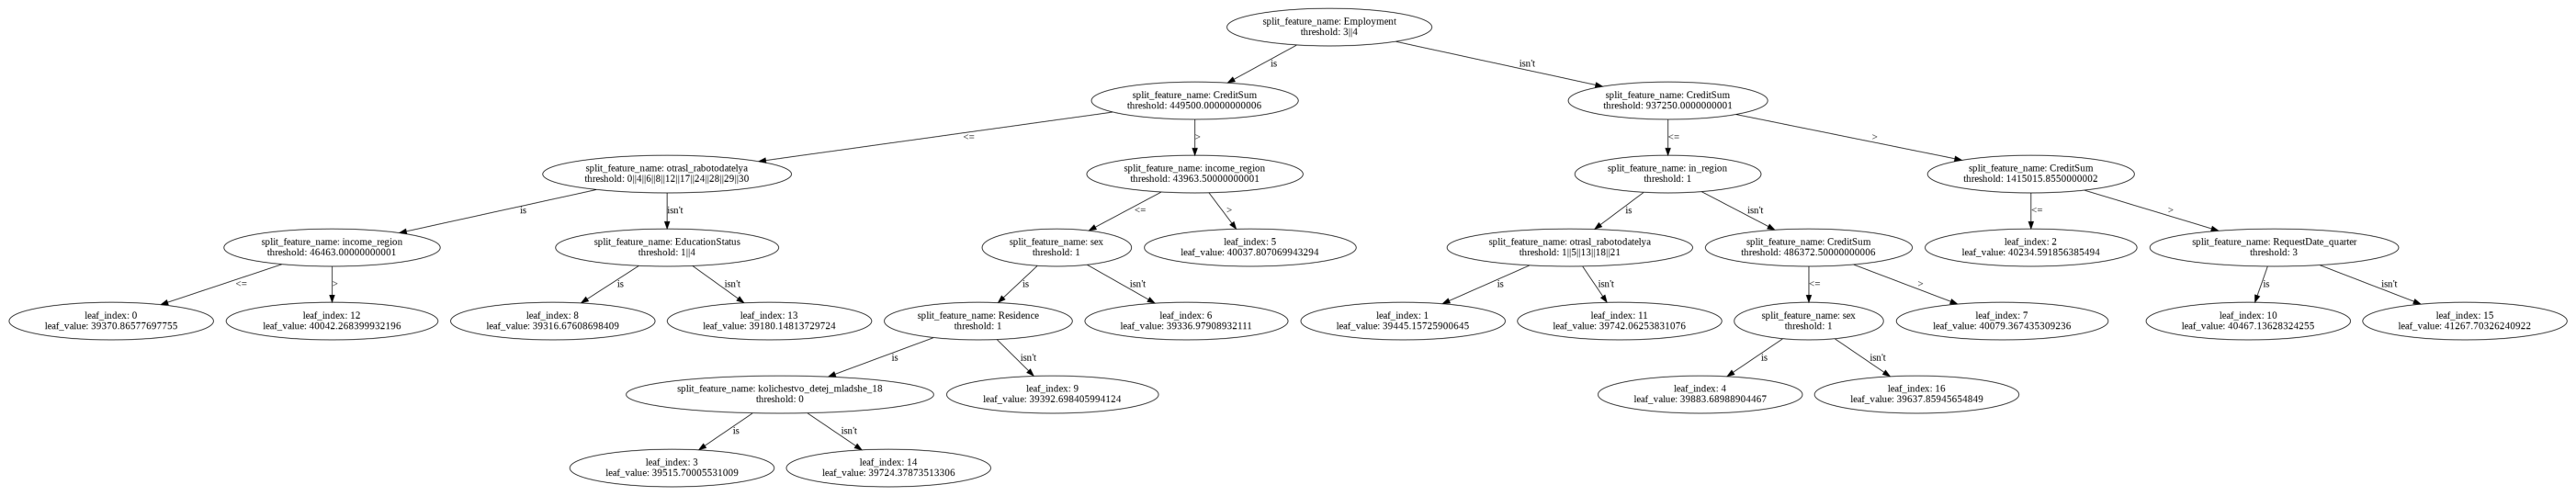

In [204]:
lgb.plot_tree(clf, tree_index=0, figsize=(50,100))

In [225]:
X_test.loc[[7151]].dtypes

ProductName                                   category
CreditSum                                      float64
TypeOfWork                                    category
Employment                                    category
SignIP                                        category
sex                                           category
age                                              int64
EducationStatus                               category
otrasl_rabotodatelya                          category
kolichestvo_rabotnikov_v_organizacii          category
OrgStanding_N                                  float64
kolichestvo_detej_mladshe_18                  category
LivingRegionName                              category
Residence                                     category
IncomeDocumentKind                            category
HaveSalaryCard                                category
IsBankWorker                                  category
harakteristika_tekutschego_trudoustrojstva    category
RequestDat

In [233]:
res = []
for n in range(700):
  res.append(clf.predict(X_test.loc[[7151]], num_iteration=n))

res

[array([139648.5533169]),
 array([41267.70326241]),
 array([43040.50686658]),
 array([44393.42213611]),
 array([45719.27910941]),
 array([47032.51916742]),
 array([48306.36375856]),
 array([49569.24370056]),
 array([50806.8660739]),
 array([52006.69259083]),
 array([53196.85559894]),
 array([54363.21533882]),
 array([55689.62889695]),
 array([57013.60583299]),
 array([58292.5735059]),
 array([59380.34243582]),
 array([60613.56289423]),
 array([61662.01198026]),
 array([62850.73394774]),
 array([63419.8353736]),
 array([64571.29894006]),
 array([65710.53444006]),
 array([66821.35214356]),
 array([67351.01620629]),
 array([68427.52202997]),
 array([69504.94760309]),
 array([70543.34177416]),
 array([71435.81104855]),
 array([72436.81296836]),
 array([73276.34458781]),
 array([74266.07911082]),
 array([75219.79919196]),
 array([75581.02591702]),
 array([76366.85335731]),
 array([76714.60181575]),
 array([77304.5433403]),
 array([77640.07191248]),
 array([78212.83147578]),
 array([78536.38

In [154]:
idx = X_ini[X_ini.sex=='Мужской'][X_ini.Employment=='Руководитель высшего звена']\
      [X_ini.CreditSum<10**6][(X_ini.age>25)&(X_ini.age<45)]\
      .index
t = y_ini[idx]
tt = X_ini.loc[idx]
idx2 = t[t>=100000]
tt[idx2]
# t[idx].plot(kind='hist')

KeyError: ignored

In [149]:
idx, X_ini.index

(Int64Index([7737, 8251, 1211, 7629, 8082, 6167, 2349, 3069, 4155, 3273,
             ...
             1708, 6928, 1321, 4975, 4533,  859,  787, 7560, 5849, 3911],
            dtype='int64', length=101),
 Int64Index([ 824,  553, 3220, 7497, 3972,  548, 6848, 6203, 1275, 5704,
             ...
             6646, 7564, 2397, 4765, 5631, 6102, 3934, 2669, 1152, 6201],
            dtype='int64', length=6375))

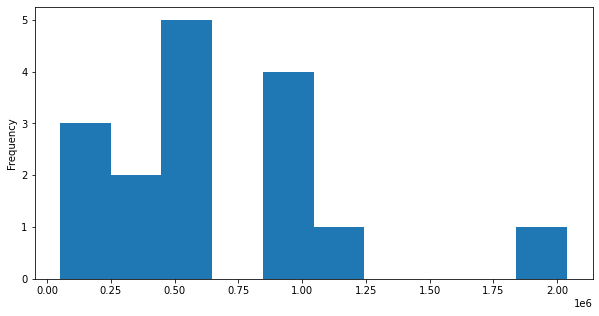

In [867]:
miss.CreditSum.plot(kind='hist')

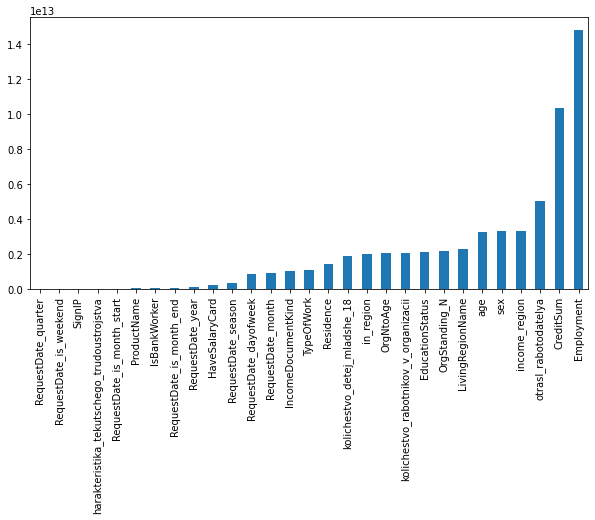

In [119]:
pd.Series(clf.feature_importance('gain'), index=clf.feature_name()).sort_values().plot(kind='bar')
features_imp = pd.Series(clf.feature_importance('gain'), index=clf.feature_name()).sort_values()
features_imp = features_imp[features_imp > 0].index

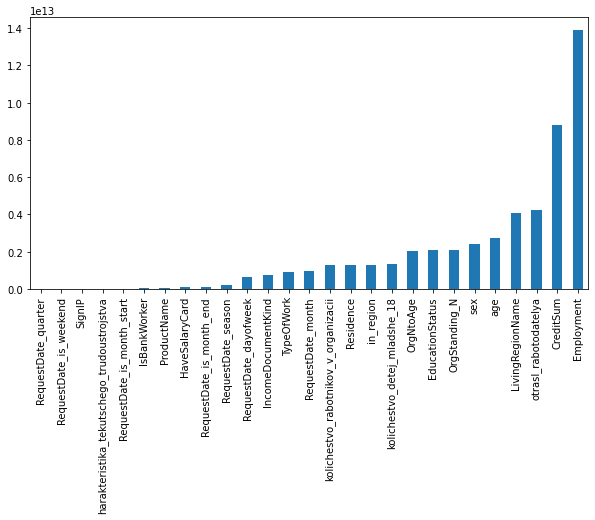

In [821]:
pd.Series(clf.feature_importance('gain'), index=clf.feature_name()).sort_values().plot(kind='bar')
features_imp = pd.Series(clf.feature_importance('gain'), index=clf.feature_name()).sort_values()
features_imp = features_imp[features_imp > 0].index

11529.828432563587


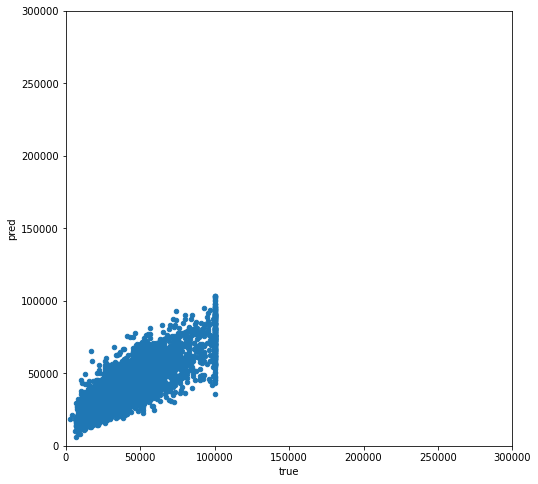

In [641]:
pred = clf.predict(X)

print(np.sqrt(mean_squared_error(y, pred)))
pd.DataFrame(np.vstack([y.values,pred]).T, columns=['true', 'pred']) \
    .plot(x='true', y='pred', kind='scatter',
          xlim=(-1,300000), ylim=(-1, 300000), figsize=(8,8));

# Null imp

In [872]:
def get_feature_importances(params, X, y, shuffle, seed=None):
    train_features = X.columns
    if shuffle:
        # Here you could as well use a binomial distribution
        y = y.sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(X, y, free_raw_data=False, silent=True)
    
    # Fit the model
    clf = lgb.train(params=params, train_set=dtrain, num_boost_round=700)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = np.sqrt(mean_squared_error(y, clf.predict(X)))
    
    return imp_df

In [873]:
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(params, X, y, shuffle=False)
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,ProductName,1.052504e+11,26,14872.622439
1,CreditSum,1.495879e+13,1849,14872.622439
2,TypeOfWork,1.724957e+12,355,14872.622439
3,Employment,2.170934e+13,465,14872.622439
4,SignIP,0.000000e+00,0,14872.622439


In [875]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(params, X, y, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of   80 (Spent   0.0 min)Done with    2 of   80 (Spent   0.0 min)Done with    3 of   80 (Spent   0.1 min)Done with    4 of   80 (Spent   0.1 min)Done with    5 of   80 (Spent   0.1 min)Done with    6 of   80 (Spent   0.1 min)Done with    7 of   80 (Spent   0.2 min)Done with    8 of   80 (Spent   0.2 min)Done with    9 of   80 (Spent   0.2 min)Done with   10 of   80 (Spent   0.2 min)Done with   11 of   80 (Spent   0.3 min)Done with   12 of   80 (Spent   0.3 min)Done with   13 of   80 (Spent   0.3 min)

In [881]:
actual_imp_df

,feature,importance_gain,importance_split,trn_score
0,ProductName,1.052504e+11,26,14872.622439
1,CreditSum,1.495879e+13,1849,14872.622439
2,TypeOfWork,1.724957e+12,355,14872.622439
3,Employment,2.170934e+13,465,14872.622439
4,SignIP,0.000000e+00,0,14872.622439
5,sex,3.249764e+12,323,14872.622439
6,age,4.057610e+12,1094,14872.622439
7,EducationStatus,2.635516e+12,250,14872.622439
8,otrasl_rabotodatelya,7.139375e+12,1076,14872.622439
9,kolichestvo_rabotnikov_v_organizacii,2.395366e+12,451,14872.622439


In [879]:
import matplotlib.pyplot as plt
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

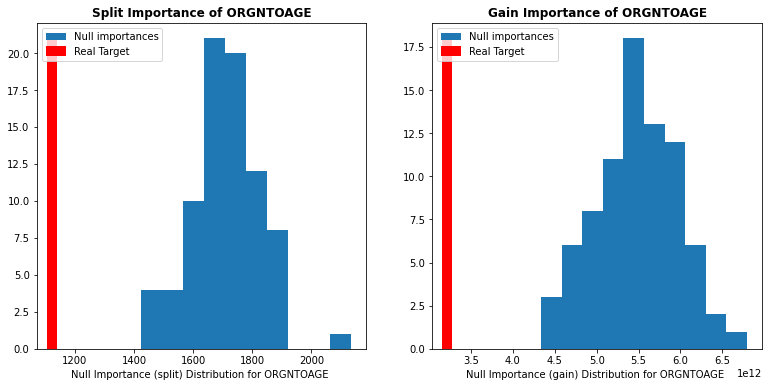

In [888]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='OrgNtoAge')

Text(0.5, 1.0, 'Feature scores wrt gain importances')

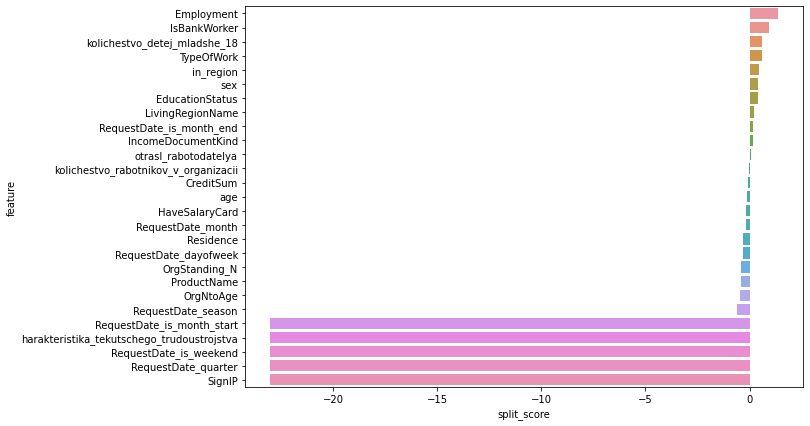

In [889]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(10, 7))
# gs = gridspec.GridSpec(1, 2)
# Plot Split importances
# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
# ax = plt.subplot(gs[0, 1])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70])
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
# plt.tight_layout()